In [12]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python.retinotopy import utils as retutils

from pipeline.python import utils as putils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf


from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

In [2]:
%matplotlib notebook

In [13]:
def filter_retino_cells(magratios, pass_criterion='all', mag_thr=0.01):
    conds = [c for c in magratios.columns if c!='blank']
    if pass_criterion=='all':
        soma_rois = [i for i in magratios.index \
                        if all(magratios[conds].loc[i] >= mag_thr)]
    elif pass_criterion=='mean':
        meanrs = magratios[conds].mean(axis=1)
        soma_rois = meanrs[meanrs>mag_thr].index.tolist()
        
    elif pass_criterion=='either':
        az_conds = [c for c in magratios.columns if c in ['right', 'left']]
        el_conds = [c for c in magratios.columns if c in ['top', 'bottom']]
        soma_rois = [i for i in magratios.index \
                    if (any(magratios[az_conds].loc[i] >= mag_thr) \
                        and (any(magratios[el_conds].loc[i] >= mag_thr))) ]

    elif pass_criterion == 'any':
        soma_rois = [i for i in magratios.index \
                        if any(magratios[conds].loc[i] >= mag_thr) ]
    return soma_rois

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### RF params
responsive_test = None
responsive_thr = None
n_stds = None
response_type = 'dff'

#### Filter RF datasets by
do_spherical_correction=False
rf_filter_by=None
rf_fit_thr=0.5
rf_type = 'sphr' if do_spherical_correction else ''
rf_fit_desc = fitrf.get_fit_desc(response_type=response_type, do_spherical_correction=do_spherical_correction)
rf_str = '%s_%s' % (rf_filter_by, rf_type)
print(rf_str)
print(rf_fit_desc)

#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.002
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr
retino_str = '%s-thr%.3f' % (pass_criterion, mag_thr)
print(retino_str)


None_
fit-2dgaus_dff-no-cutoff
pixels-thr0.002


In [5]:
# Set data identifiers
fig_id = '%s|%s|%s -- ret: %s| rf: %s, filter %s' % (fov_type, state, traceid, retino_str, rf_fit_desc, rf_str)
print(fig_id)


zoom2p0x|awake|traces001 -- ret: pixels-thr0.002| rf: fit-2dgaus_dff-no-cutoff, filter None_


# Output dir

In [6]:
basedir = os.path.join(aggr_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc), 'compare_retino')

if not os.path.exists(basedir):
    os.makedirs(basedir)
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/compare_retino'

# Metadata

In [7]:
sdata = aggr.get_aggregate_info(traceid=traceid)
rdata = sdata[sdata['experiment'].isin(['retino', 'rfs', 'rfs10'])]
edata = aggr.include_dsets_with(rdata, experiment='retino', also_include='rfs')
both_datakeys = edata['datakey'].unique()
print(len(both_datakeys))

Segmentation: missing 9 dsets
45


In [8]:
print(rdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(edata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

             datakey
visual_area         
Li                26
Ll                 4
Lm                23
V1                19
             datakey
visual_area         
Li                16
Ll                 2
Lm                17
V1                19


In [9]:
missing_rfs = sdata[(sdata['experiment']=='retino') & ~(sdata['datakey'].isin(both_datakeys))]['datakey'].unique()
print("Missing RFs for %i datasets:" % len(missing_rfs))
for m in missing_rfs:
    print m

Missing RFs for 14 datasets:
20190314_JC070_fov1
20190315_JC070_fov1
20190315_JC070_fov2
20190316_JC070_fov1
20190319_JC067_fov1
20190320_JC067_fov1
20190321_JC070_fov1
20190322_JC073_fov1
20190327_JC073_fov1
20190422_JC076_fov1
20190306_JC061_fov2
20190306_JC061_fov3
20190314_JC070_fov2
20190315_JC070_fov3


# Load RF fits

In [10]:
print("Loading RF fits (%s)" % rf_fit_desc)
rfdf = rfutils.load_rfdf_with_positions(rf_fit_desc, traceid='traces001', filter_by=None, reliable_only=True)

#### Average rf/rf10 together to get maximal cells
rfdf_avg = aggr.get_rfdata(rfdf, rfdf, average_repeats=True)

Loading RF fits (fit-2dgaus_dff-no-cutoff)
Loading existing RF coord conversions...


In [154]:
# datakey = '20190602_JC091_fov1'
# visual_area='Li'
datakey = '20190622_JC085_fov1'
visual_area='V1'
retinorun='retino_run1'

currdf = rfdf_avg[(rfdf_avg['visual_area']==visual_area) & (rfdf_avg['datakey']==datakey)]
curr_rois = currdf['cell'].unique()
currdf.shape
incl_rois = None

In [492]:
session, animalid, fovnum = putils.split_datakey_str(datakey)
fov='FOV%i_zoom2p0x' % fovnum

fft_results = retutils.load_fft_results(animalid, session, fov, retinorun=retinorun, 
                traceid=traceid, create_new=True, trace_type='raw', detrend_after_average=True)

# fft_results['fft_soma']
magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_results['fft_soma']) # return -pi, pi

... loading paradigm info
Found 16 tifs
Temporal ds: 5.00
... loading traces (neuropil)
... loading traces (raw)


In [310]:
reload(retutils)

<module 'pipeline.python.retinotopy.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/utils.py'>

In [486]:
def make_stimulus(bar_pos, cond='left',  n_frames_per_cycle=186, n_cycles=12):
    

    mwpos = bar_pos - bar_pos.min()

    iframes = np.linspace(mwpos[cond].iloc[0], mwpos[cond].iloc[-1], n_frames_per_cycle)
    iframes = [int(round(i)) for i in iframes]
    total_frames = iframes*n_cycles

    stimsize = len(iframes) 

    # Create stimulus:
    stimulus = np.zeros((stimsize, stimsize), dtype=np.int8)
    if cond in ['left', 'right']:
        stimulus[:, 0:2] = 1
    else:
        stimulus[0:2, :] = 1

    direction = -1 if cond in ['right', 'top'] else 1
    pos_int = 0
    stim_list=[]
    axis=1 if cond in ['right', 'left'] else 0
    for fi, fpos in enumerate(total_frames): #iframes):
        stimulus = np.roll(stimulus, direction, axis=axis)
        stim_list.append(stimulus)
        
    stim_mov = np.array(stim_list)
    
    return stim_mov



In [311]:
mwinfo = retutils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = retutils.get_protocol_info(animalid, session, fov, run=retinorun)
stiminfo, trials_by_cond = retutils.get_retino_stimulus_info(mwinfo, scaninfo)
    
print "-----------------------------------"
print "Getting MW info (stimulus positions)"
bar_p = dict()
bar_t = dict()
for cond in scaninfo['trials'].keys():
    bar_p[cond], bar_t[cond] = retutils.get_interp_positions(cond, mwinfo, stiminfo, trials_by_cond)
bar_pos = pd.concat([pd.Series(v.mean(axis=1), name=k) for k, v in stim_positions.items()], axis=1)


-----------------------------------
Getting MW info (stimulus positions)
[top]: Downsampling MW positions (sampled at 60.00Hz) to SI frame rate (44.65Hz)
[right]: Downsampling MW positions (sampled at 60.00Hz) to SI frame rate (44.65Hz)
[bottom]: Downsampling MW positions (sampled at 60.00Hz) to SI frame rate (44.65Hz)
[left]: Downsampling MW positions (sampled at 60.00Hz) to SI frame rate (44.65Hz)


In [487]:
cond='left'
n_frames_per_cycle = stiminfo[cond]['n_frames_per_cycle']
n_cycles = stiminfo[cond]['n_cycles']
bar_movies = dict((k, make_stimulus(bar_pos, cond=k, n_frames_per_cycle=n_frames_per_cycle, n_cycles=n_cycles)) \
                  for k in retino_conds)
nf, sx, sy = bar_movies['left'].shape

bar_movies = dict((k, v.reshape((nf, sx*sy)).astype(float)) for k, v in bar_movies.items())


In [488]:
# Do fft
n_frames = 2232 #scaninfo['stimulus']['n_frames']
frame_rate = 44.65 #scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']

#### label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate))
sorted_freq_idxs = np.argsort(freqs)

fft_bar = dict((cond, retutils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) \
                for cond, tdf in bar_movies.items())


<IPython.core.display.Javascript object>


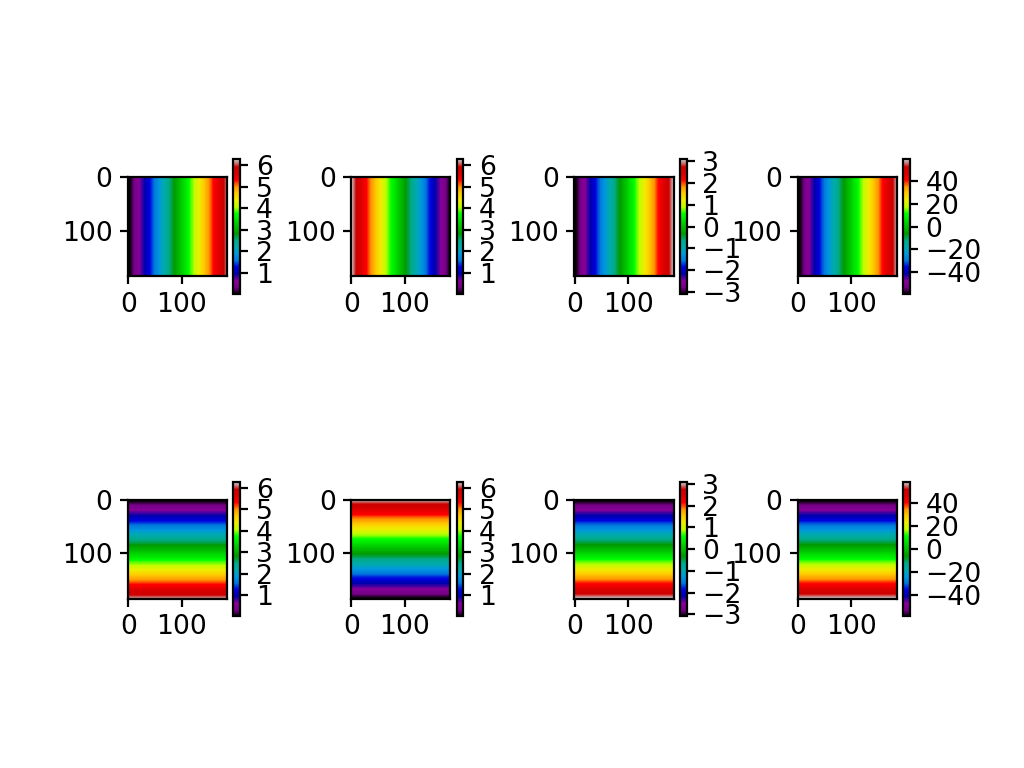

In [560]:
magratios, phases = retutils.extract_from_fft_results(fft_bar)
cmap='nipy_spectral'
phases_wb = retutils.correct_phase_wrap(phases)
ph_right = phases_wb['right'].reshape((sx, sy))
ph_left = phases_wb['left'].reshape((sx, sy))

ph_top = phases_wb['top'].reshape((sx, sy))
ph_bottom = phases_wb['bottom'].reshape((sx, sy))

fig, axn = pl.subplots(2,4) #.figure(1, 3)
ax=axn[0,0]
im=ax.imshow(ph_left, cmap=cmap)
pl.colorbar(im, ax=ax, shrink=0.5)

ax=axn[0,1]
im=ax.imshow(ph_right, cmap=cmap)
pl.colorbar(im, ax=ax, shrink=0.5)

ax=axn[0,2]
ph_abs = (ph_left - ph_right)/2.
im=ax.imshow(ph_abs, cmap=cmap)
pl.colorbar(im, ax=ax, shrink=0.5)

ax=axn[0,3]
ph_lin = retutils.convert_range(ph_abs, oldmin=-np.pi, oldmax=np.pi, newmin=screen_min, newmax=screen_max)
im=ax.imshow(ph_lin, cmap=cmap)
pl.colorbar(im, ax=ax, shrink=0.5)

#--------
ax=axn[1,0]
im=ax.imshow(ph_bottom, cmap=cmap)
pl.colorbar(im, ax=ax, shrink=0.5)

ax=axn[1,1]
im=ax.imshow(ph_top, cmap=cmap)
pl.colorbar(im, ax=ax, shrink=0.5)

ax=axn[1,2]
ph_abs_el = (ph_bottom - ph_top)/2.
im=ax.imshow(ph_abs_el, cmap=cmap)
pl.colorbar(im, ax=ax, shrink=0.5)

ax=axn[1,3]
ph_lin_el = retutils.convert_range(ph_abs_el, oldmin=-np.pi, oldmax=np.pi, newmin=screen_min, newmax=screen_max)
im=ax.imshow(ph_lin_el, cmap=cmap)
pl.colorbar(im, ax=ax, shrink=0.5)

pl.subplots_adjust(wspace=0.8)

In [573]:
delay_az_bar = retutils.correct_phase_wrap( (ph_left+ph_right)/2.)
delay_el_bar = retutils.correct_phase_wrap( (ph_bottom+ph_top)/2. )
print(delay_az_bar.min(), delay_az_bar.max())
print(delay_el_bar.min(), delay_el_bar.max())

(0.03378056616763203, 3.1753732197574256)
(0.03378056616763203, 3.1753732197574256)


<IPython.core.display.Javascript object>


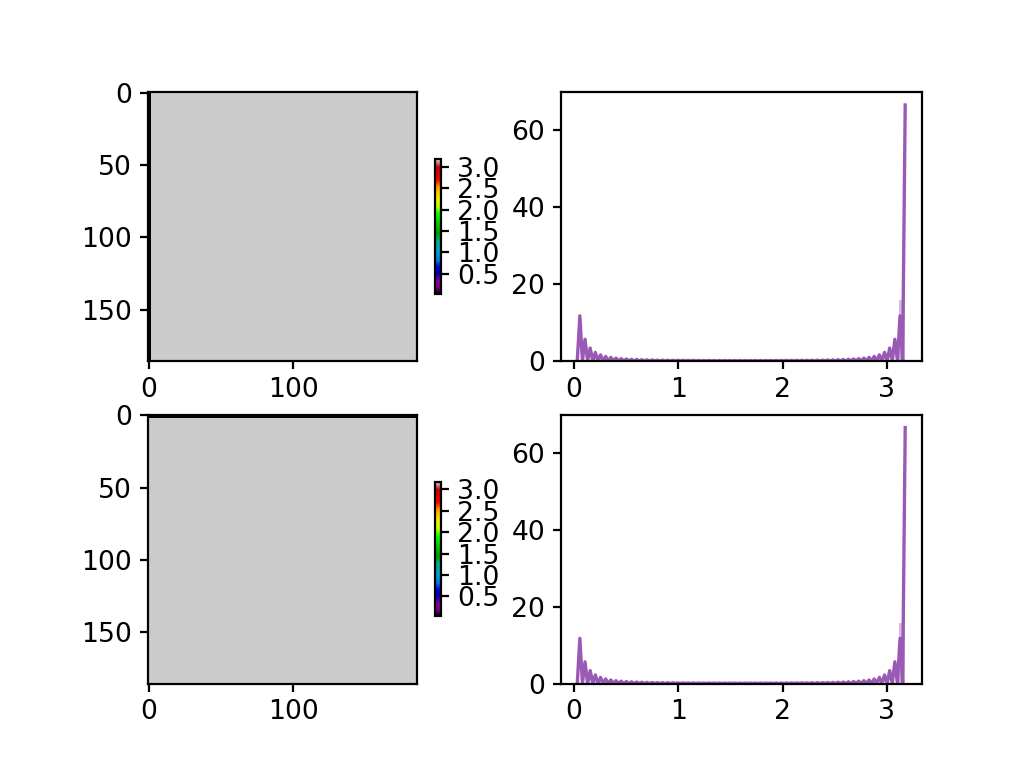

In [575]:
f, axn = pl.subplots(2,2)
im=axn[0,0].imshow(delay_az_bar, cmap=cmap)
pl.colorbar(im, ax=axn[0,0], shrink=0.5)

sns.distplot(delay_az_bar.ravel(), ax=axn[0,1])


im=axn[1,0].imshow(delay_el_bar, cmap=cmap)
pl.colorbar(im, ax=axn[1,0], shrink=0.5)

sns.distplot(delay_el_bar.ravel(), ax=axn[1,1])


In [576]:
# Get absolute coords
phases_w = retutils.correct_phase_wrap(phases_soma) # wraps from 0 to 2pi
# phases_w2 = retutils.make_continuous(phases_soma)
absolute_az = (phases_w['left'] - phases_w['right']) / 2.  # cont (-pi, pi)
absolute_el = (phases_w['bottom'] - phases_w['top']) / 2.

delay_az = retutils.correct_phase_wrap( (phases_w['left'] + phases_w['right']) / 2. )
delay_el = retutils.correct_phase_wrap( (phases_w['bottom'] + phases_w['top']) / 2. )


ph_left = phases_soma['left']
ph_right = phases_soma['right']
absolute_az = (retutils.correct_phase_wrap(ph_left) - retutils.correct_phase_wrap(ph_right))/2.
print(absolute_az.min(), absolute_az.max())

(-2.8549929327357453, 2.774038373842301)


In [555]:
delay_az.min(), delay_az.max()

(0.22650445021891308, 5.907238605438239)

In [556]:
delay_thr=1.
pass_delay = np.union1d(delay_az[delay_az<=delay_thr].index.tolist(), delay_el[delay_el<=delay_thr].index.tolist())
len(pass_delay)

13

In [557]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

screen_top = screen['altitude_deg']/2.
screen_right = screen['azimuth_deg']/2.
elev_cutoff = screen_top / screen_right
print(elev_cutoff)

vmin, vmax = -np.pi, np.pi
lin_az = retutils.convert_range(absolute_az, oldmin=-np.pi, oldmax=np.pi, newmin=screen_min, newmax=screen_max)
lin_el = retutils.convert_range(absolute_el, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)
retino_pos = pd.DataFrame({'az': lin_az, 'el': lin_el}).astype(float)


0.563106617463


In [558]:
retinodf = retino_pos.loc[curr_rois]
retinodf['az'].min(), retinodf['az'].max()

(-47.01800480530318, 45.05252758682323)

8 of 20 cells pass (118 cells in area)


<IPython.core.display.Javascript object>


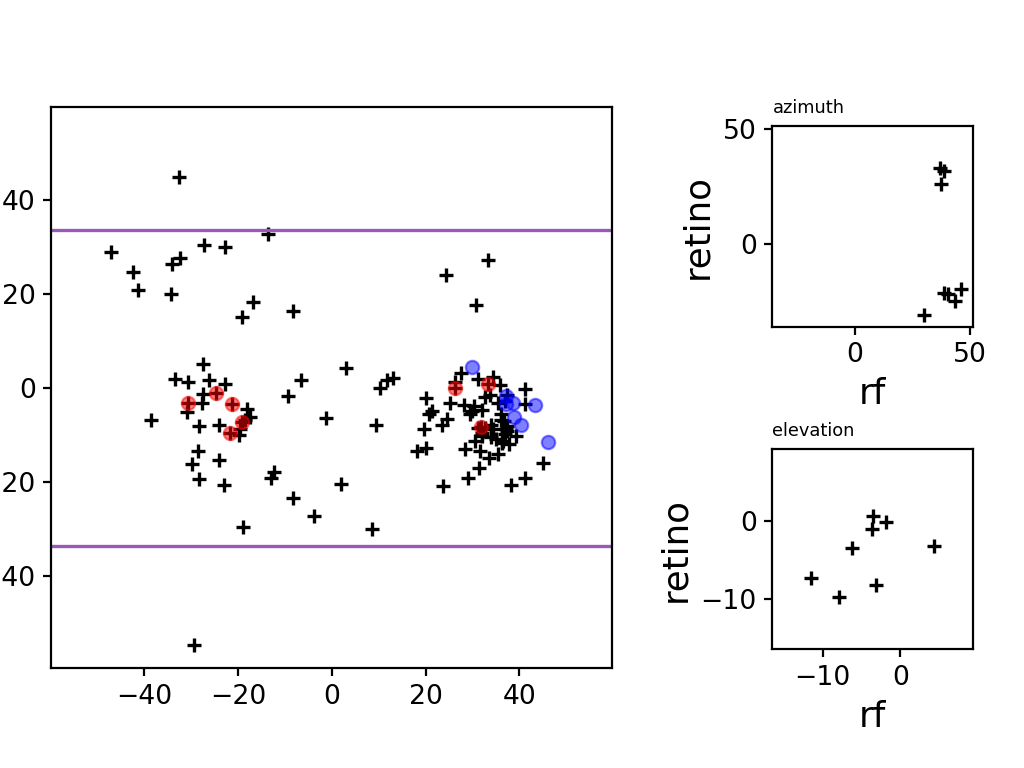

In [577]:
pass_rois = filter_retino_cells(magratios_soma, pass_criterion='mean', mag_thr=0.02)
incl_rois = np.intersect1d(pass_rois, curr_rois)
print("%i of %i cells pass (%i cells in area)" % (len(incl_rois), len(pass_rois), len(curr_rois)))


fig = pl.figure()
gs = gridspec.GridSpec(2,3) #fig.add_gridspec(2,2)

# RETINO.
ax=fig.add_subplot(gs[0:2, 0:-1])
ax.set_xlim([-screen_max, screen_max])
ax.set_ylim([-screen_max, screen_max])
vmin, vmax = screen_min, screen_max
ax.axhline(y=vmin*elev_cutoff)
ax.axhline(y=vmax*elev_cutoff)
ax.set_aspect('equal')
# RETINO:  plot all
ax.scatter(retinodf['az'], retinodf['el'], c='k', marker='+', label='all')

# RETINO:  plot well-fit
ax.scatter(retinodf.loc[incl_rois]['az'], retinodf.loc[incl_rois]['el'], c='r', marker='o', alpha=0.5)

# RFS:  plot positions
rf_x = currdf[currdf['cell'].isin(incl_rois)]['x0'].copy()
rf_y = currdf[currdf['cell'].isin(incl_rois)]['y0'].copy()
ax.scatter(rf_x, rf_y, c='b', alpha=0.5)


# compare ----------------
# retino_x = np.array([x.loc[i] if i in x.index else np.nan for i in incl_rois])
# retino_y = np.array([y.loc[i] if i in y.index else np.nan for i in incl_rois])
retino_x = retinodf.loc[incl_rois]['az']
retino_y = retinodf.loc[incl_rois]['el']

# X-POSITION 
ax=fig.add_subplot(gs[0, -1])
min_x = min([rf_x.min(), retino_x.min()])
max_x = max([rf_x.max(), retino_x.max()])
ax.set_title('azimuth', fontsize=8, loc='left')

ax.scatter(rf_x, retino_x, c='k', marker='+')
ax.set_ylim([min_x-5, max_x+5])
ax.set_xlim([min_x-5, max_x+5])
ax.set_aspect('equal')

ax.set_xlabel('rf')
ax.set_ylabel('retino')

# Y-POSITION
ax=fig.add_subplot(gs[1, -1])
min_y = min([rf_y.min(), retino_y.min()])
max_y = max([rf_y.max(), retino_y.max()])
ax.set_title('elevation', fontsize=8, loc='left')

ax.scatter(rf_y, retino_y, c='k', marker='+')
ax.set_ylim([min_y-5, max_y+5])
ax.set_xlim([min_y-5, max_y+5])
ax.set_aspect('equal')
ax.set_xlabel('rf')
ax.set_ylabel('retino')

pl.subplots_adjust(wspace=0.8, right=0.95, left=0.05)

In [501]:
#20190522_JC084_fov1: currdf[currdf['cell'].isin([178, 236, 237])][['cell', 'x0', 'y0', 'std_x', 'std_y', 'r2']]


funky = retinodf[retinodf['az']<0].loc[incl_rois].dropna().index.tolist() 

currdf[currdf['cell'].isin(funky)][['cell', 'x0', 'y0', 'std_x', 'std_y', 'r2']]

,cell,x0,y0,std_x,std_y,r2
2060,175,38.786798,-6.191034,12.087727,10.345811,0.673327


In [502]:
retinodf.loc[funky]

,az,el
175,-21.277743,-3.474901


In [503]:
retino_ = retinodf.loc[incl_rois].copy()
rf_ = currdf[currdf['cell'].isin(incl_rois)][['cell', 'x0', 'y0', 'std_x', 'std_y', 'r2']].copy()
rf_ = rf_.rename(index=dict((i, r) for i, r in zip(rf_.index.tolist(), incl_rois)))

In [504]:
pd.concat([retino_, rf_], axis=1)

,az,el,cell,x0,y0,std_x,std_y,r2
175,-21.277743,-3.474901,175,38.786798,-6.191034,12.087727,10.345811,0.673327


In [521]:
rid = funky[0]
phases_w.loc[rid]

bottom    4.324214
left      0.188286
right     2.424754
top       4.689455
Name: 175, dtype: float64

In [506]:
screen_min, screen_max

(-59.7782, 59.7782)

In [507]:
retutils.convert_range(phases_w.loc[57], oldmin=0, oldmax=2*np.pi, newmin=screen_min, newmax=screen_max)


bottom    13.331186
left     -57.429560
right    -14.036984
top       32.773848
Name: 57, dtype: float64

In [183]:
(0.123431-2.403891)/2.

-1.1402299999999999

In [508]:
soma_traces = retutils.load_traces(animalid, session, fov, run=retinorun,
                        analysisid='traces001', trace_type='raw', detrend_after_average=True)

... loading traces (raw)
Specified ID <traces001> not eligible. Selecting 1st of [u'analysis002']


<IPython.core.display.Javascript object>


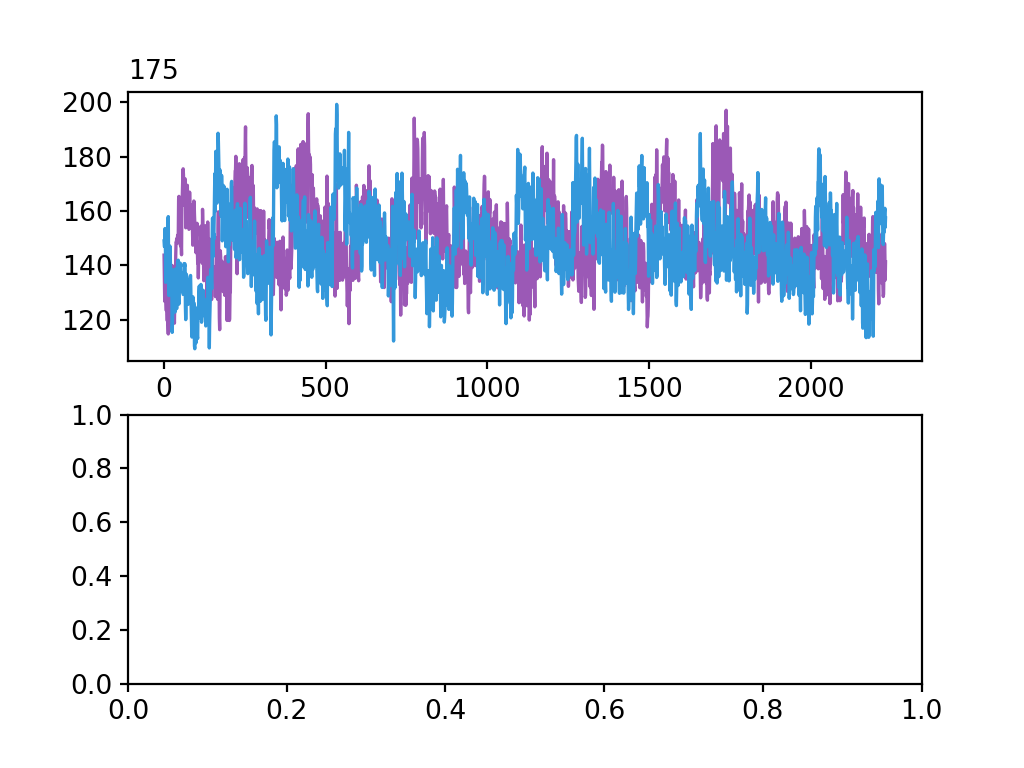

In [509]:

fig, axn = pl.subplots(len(funky)+1, 1)

retino_conds = soma_traces.keys()

for ax, rid in zip(axn.flat, funky):
    for cond in retino_conds:
        if cond in ['right', 'left']:
            
            ax.plot(soma_traces[cond][rid], label=cond)
    ax.set_title(rid, loc='left')

<IPython.core.display.Javascript object>


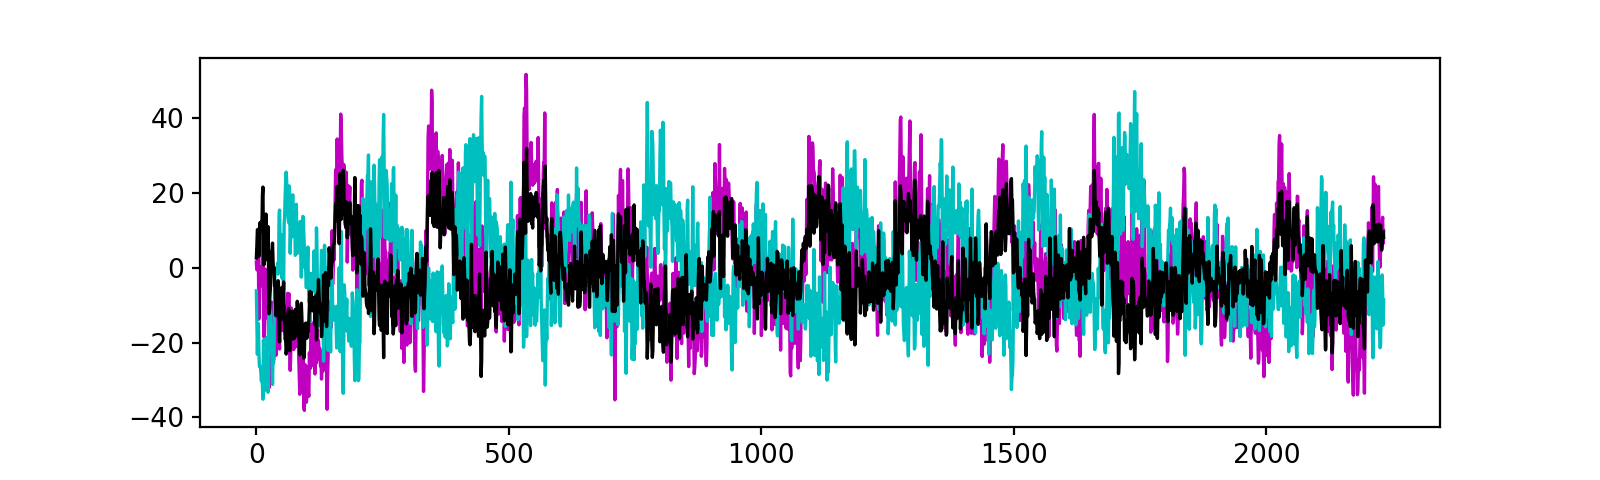

In [517]:
vals = (soma_traces['left'][rid].values - soma_traces['right'][rid].values)/2.
pl.figure(figsize=(10,3))
pl.plot(soma_traces['left'][rid]-soma_traces['left'][rid].mean(), 'm')
pl.plot(soma_traces['right'][rid]-soma_traces['right'][rid].mean(), 'c')
pl.plot(vals, 'k')


In [77]:
(phases_soma['left'][rid]-phases_soma['right'][rid])/2.

1.1182337434534133

In [78]:
absolute_az[rid]

-1.1182337434534133